<a href="https://colab.research.google.com/github/irwanphan/FNWL/blob/main/Classify_Yoga_Poses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Yoga Pose
- **Nama:** Irwan Kurnia Phan
- **Email:** irwanphan@gmail.com
- **ID Dicoding:** irwanphan

## Import Semua Packages/Library yang Digunakan

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TFSMLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import random

!pip install tensorflowjs
import tensorflowjs as tfjs

from google.colab import files
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [3]:
!pip freeze > requirements.txt

## Data Preparation

### Data Loading

In [4]:
! mkdir kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download shrutisaxena/yoga-pose-image-classification-dataset
! kaggle datasets download amanupadhyay/yoga-poses

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/amanupadhyay/yoga-poses
License(s): unknown
 99% 159M/160M [00:10<00:00, 20.8MB/s]
100% 160M/160M [00:10<00:00, 16.5MB/s]


In [5]:
! unzip yoga-poses.zip

Archive:  yoga-poses.zip
  inflating: yoga_poses/test/chair/guy3_chair070.jpg  
  inflating: yoga_poses/test/chair/guy3_chair070_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair071.jpg  
  inflating: yoga_poses/test/chair/guy3_chair071_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair072.jpg  
  inflating: yoga_poses/test/chair/guy3_chair072_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair073.jpg  
  inflating: yoga_poses/test/chair/guy3_chair073_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair074.jpg  
  inflating: yoga_poses/test/chair/guy3_chair074_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair075.jpg  
  inflating: yoga_poses/test/chair/guy3_chair075_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair076.jpg  
  inflating: yoga_poses/test/chair/guy3_chair076_flipped.jpg  
  inflating: yoga_poses/test/chair/guy3_chair077.jpg  
  inflating: yoga_poses/test/chair/guy3_chair077_flipped.jpg  
  inflating: yoga_poses/test/ch

### Data Preprocessing

#### Split Dataset

In [6]:
# Folder dari dataset Kaggle
train_directory = 'yoga_poses/train'
test_directory = 'yoga_poses/test'

# Folder sementara simpan semua gambar
temp_dataset_dir = 'yoga_poses_temp'
os.makedirs(temp_dataset_dir, exist_ok=True)

# Dapatkan daftar kelas dari dataset
classes = os.listdir(train_directory)

# Splitting ulang karena default ratio dataset test dan train bukan 80:20
for cls in classes:
    os.makedirs(os.path.join(temp_dataset_dir, cls), exist_ok=True)
    train_cls_folder = os.path.join(train_directory, cls)
    test_cls_folder = os.path.join(test_directory, cls)
    for folder in [train_cls_folder, test_cls_folder]:
        images = os.listdir(folder)
        for img in images:
            src = os.path.join(folder, img)
            dst = os.path.join(temp_dataset_dir, cls, img)
            shutil.move(src, dst)
# Bersihkan folder train dan test yang ada
for cls in classes:
    os.makedirs(os.path.join(train_directory, cls), exist_ok=True)
    os.makedirs(os.path.join(test_directory, cls), exist_ok=True)
# Set ratio
split_ratio = 0.8

for cls in classes:
    cls_folder = os.path.join(temp_dataset_dir, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)

    train_size = int(len(images) * split_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    for img in train_images:
        src = os.path.join(cls_folder, img)
        dst = os.path.join(train_directory, cls, img)
        shutil.move(src, dst)

    for img in test_images:
        src = os.path.join(cls_folder, img)
        dst = os.path.join(test_directory, cls, img)
        shutil.move(src, dst)

# Hapus folder sementara
shutil.rmtree(temp_dataset_dir)

print("Dataset berhasil dibagi ulang menjadi training dan testing set dengan rasio 80:20.")

# Hitung jumlah file di setiap subfolder dan total keseluruhan
def count_files_in_directory(directory):
    total_files = 0
    for cls in os.listdir(directory):
        cls_folder = os.path.join(directory, cls)
        if os.path.isdir(cls_folder):
            num_files = len(os.listdir(cls_folder))
            print(f"Jumlah file di folder '{cls_folder}': {num_files}")
            total_files += num_files
    return total_files

print("\nJumlah file setelah splitting ulang:")

# Tampilkan jumlah file di masing-masing folder train dan total
print("\nTraining Set:")
total_train_files = count_files_in_directory(train_directory)
print(f"Total jumlah file di folder 'train': {total_train_files}")

# Tampilkan jumlah file di masing-masing folder test dan total
print("\nTest Set:")
total_test_files = count_files_in_directory(test_directory)
print(f"Total jumlah file di folder 'test': {total_test_files}")

Dataset berhasil dibagi ulang menjadi training dan testing set dengan rasio 80:20.

Jumlah file setelah splitting ulang:

Training Set:
Jumlah file di folder 'yoga_poses/train/cobra': 505
Jumlah file di folder 'yoga_poses/train/no_pose': 20
Jumlah file di folder 'yoga_poses/train/chair': 454
Jumlah file di folder 'yoga_poses/train/traingle': 44
Jumlah file di folder 'yoga_poses/train/dog': 464
Jumlah file di folder 'yoga_poses/train/tree': 488
Jumlah file di folder 'yoga_poses/train/warrior': 494
Jumlah file di folder 'yoga_poses/train/shoudler_stand': 47
Total jumlah file di folder 'train': 2516

Test Set:
Jumlah file di folder 'yoga_poses/test/cobra': 127
Jumlah file di folder 'yoga_poses/test/no_pose': 6
Jumlah file di folder 'yoga_poses/test/chair': 114
Jumlah file di folder 'yoga_poses/test/traingle': 11
Jumlah file di folder 'yoga_poses/test/dog': 116
Jumlah file di folder 'yoga_poses/test/tree': 122
Jumlah file di folder 'yoga_poses/test/warrior': 124
Jumlah file di folder 'yoga

## Modelling

In [7]:
# Pemodelan
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(8, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluasi dan Visualisasi

In [8]:
# Pemrosesan Data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [9]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2514 images belonging to 8 classes.
Found 632 images belonging to 8 classes.


In [10]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Pelatihan Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('yoga_pose_model.keras', save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10, verbose=1)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  78/2514 ━━━━━━━━━━━━━━━━━━━━ 17:20 427ms/step - accuracy: 0.1990 - loss: 2.6314

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.72701, saving model to yoga_pose_model.keras
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.2185 - loss: 2.0715 - val_accuracy: 0.2658 - val_loss: 1.7270
Epoch 2/30
  79/2514 ━━━━━━━━━━━━━━━━━━━━ 15:03 371ms/step - accuracy: 0.2956 - loss: 1.6695
Epoch 2: val_loss improved from 1.72701 to 1.41419, saving model to yoga_pose_model.keras
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - accuracy: 0.2986 - loss: 1.6394 - val_accuracy: 0.4731 - val_loss: 1.4142
Epoch 3/30
  78/2514 ━━━━━━━━━━━━━━━━━━━━ 16:06 397ms/step - accuracy: 0.3577 - loss: 1.5203
Epoch 3: val_loss improved from 1.41419 to 1.20847, saving model to yoga_pose_model.keras
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.3796 - loss: 1.5026 - val_accuracy: 0.5744 - val_loss: 1.2085
Epoch 4/30
  79/2514 ━━━━━━━━━━━━━━━━━━━━ 15:22 379ms/step - accuracy: 0.4097 - loss: 1.4406
Epoch 4: val_loss improved from 1.20847 to 1.11105, saving model to yoga_pose_model.keras
2

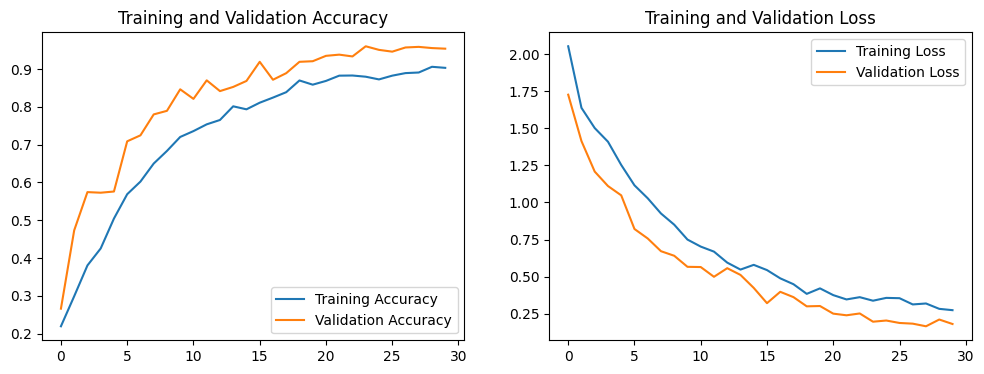

In [12]:
# Plot Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Konversi Model

In [13]:
# model.save('saved_model/yoga_pose_model.keras')
tf.saved_model.save(model, 'saved_model')
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('yoga_pose_model.tflite', 'wb') as f:
    f.write(tflite_model)

tfjs_target_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

Saved artifact at '/tmp/tmp8cg3qklk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  134287121173488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284773821776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738571152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738573440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738891792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738894608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738895136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284738898656: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [14]:
uploaded = files.upload()

if uploaded:
    # Nama file gambar yang diupload
    img_path = list(uploaded.keys())[0]

    # model = load_model('saved_model/yoga_pose_model.keras')
    model = TFSMLayer("saved_model/", call_endpoint='serving_default')

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # predictions = model.predict(img_array)
    predictions = model(img_array)

    prediction_values = predictions['output_0']

    print("Shape of predictions:", prediction_values.shape)

    # Jika prediksi satu dimensi, ubah axis dari 1 menjadi 0
    if prediction_values.ndim == 1:
        predicted_class = np.argmax(prediction_values, axis=0)
    else:
        predicted_class = np.argmax(prediction_values, axis=1)

    print(f"Kelas prediksi (SavedModel): {predicted_class}")
else:
    print("Tidak ada gambar yang diunggah.")

Saving jeune_femme_dans_une_posture_de_yoga_d_equilibre.webp to jeune_femme_dans_une_posture_de_yoga_d_equilibre.webp
Shape of predictions: (1, 8)
Kelas prediksi (SavedModel): [4]
